In [1]:
%reload_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np

from nzdownscale.dataprocess.stations import ProcessStations
from nzdownscale.dataprocess.utils import PlotData
from nzdownscale.dataprocess.config import VAR_STATIONS

### Plot Stations

Ideally I would have this for a given date, and the stations would be coloured by the station values. 

In [2]:
var = "temperature"
process_stations = ProcessStations()
all_stations = process_stations.get_path_all_stations(var)
print(len(all_stations))

444


In [3]:
f = all_stations[0]
ds = process_stations.load_station(f)
da = process_stations.ds_to_da(ds, var)

# takes a couple of minutes
df = process_stations.get_metadata_df(var)

Loading stations: 100%|██████████| 444/444 [00:38<00:00, 11.51it/s]


In [4]:
df

,start_year,end_year,duration_years,lon,lat,station_id
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/2473.nc,1978,1991,13,175.61100,-40.98000,2473
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/25162.nc,2003,2019,16,175.06906,-37.78832,25162
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/3910.nc,1980,2019,39,170.98428,-42.71228,3910
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/26170.nc,2006,2019,13,171.80500,-43.90500,26170
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/1192.nc,1990,1999,9,173.83500,-35.94400,1192
...,...,...,...,...,...,...
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/40983.nc,2015,2019,4,175.23805,-38.86145,40983
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/41163.nc,2012,2019,7,169.37549,-45.21452,41163
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/2136.nc,1979,2019,40,174.70700,-38.17100,2136
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/3145.nc,1961,2012,51,174.98400,-40.90700,3145


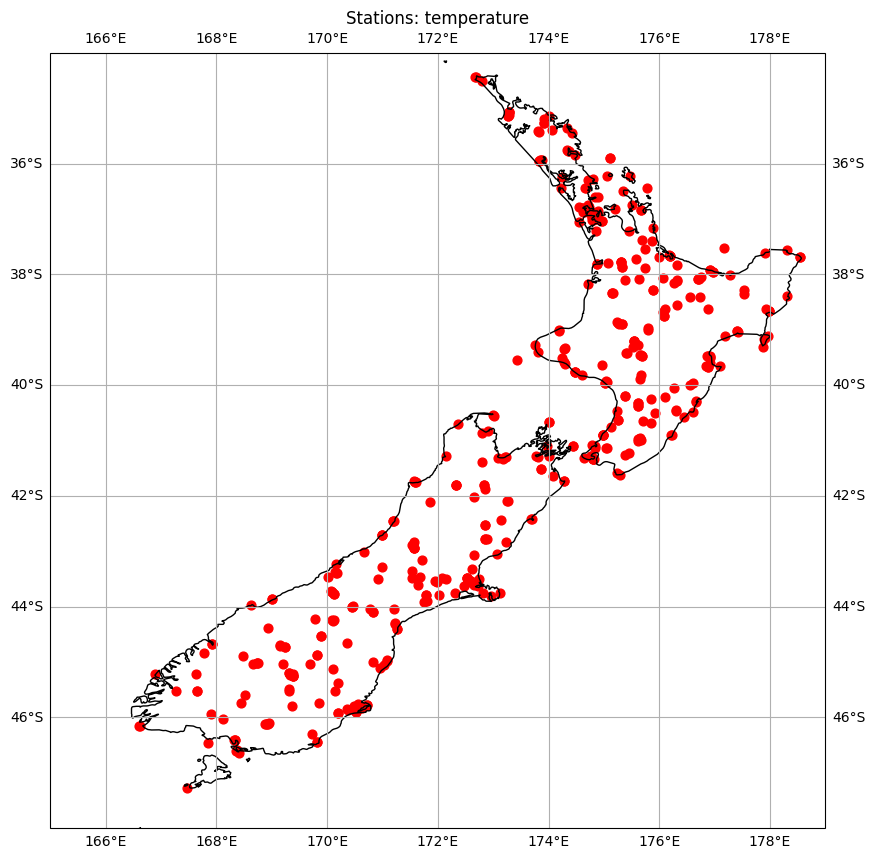

In [5]:
ax = process_stations.plot_stations_on_map(df)
plt.title(f"Stations: {var}")
# plt.savefig('./tmp/fig.png')
plt.show()

### ERA5 

Plot ERA5-land data.

In [6]:
from nzdownscale.dataprocess.era5 import ProcessERA5

In [7]:
era5 = ProcessERA5()
era5_ds = era5.load_ds(var, [2016])
era5_da = era5.ds_to_da(era5_ds, var)

In [8]:
cbar_kwargs = {"location": "right", "pad": 0.06, "shrink": 0.7, "extend": "both"}

In [9]:
daily_average = era5_da.resample(time="1D").mean()
daily_average

<xarray.DataArray 't2m' (time: 366, latitude: 191, longitude: 221)>
dask.array<stack, shape=(366, 191, 221), dtype=float32, chunksize=(1, 191, 221), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 161.0 161.1 161.2 161.3 ... 182.8 182.9 183.0
  * latitude   (latitude) float32 -31.0 -31.1 -31.2 -31.3 ... -49.8 -49.9 -50.0
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-31

<Figure size 1000x1000 with 0 Axes>

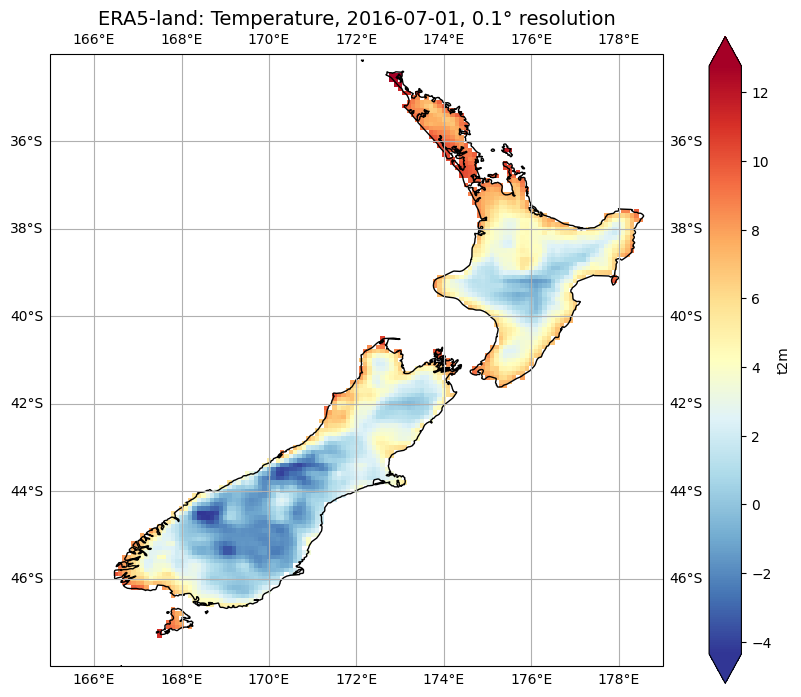

In [10]:
era5_plotnz = PlotData()
era5_fig = plt.figure(figsize=(10, 10))
era5_ax = era5_plotnz.nz_map_with_coastlines()
daily_average = era5_da.resample(time="1D").mean()
era5_da_to_plot = daily_average.sel(time="2016-07-01")
min_value, max_value = era5_da_to_plot.min().values, era5_da_to_plot.max().values
era5_p = era5_da_to_plot.plot(
    cbar_kwargs=cbar_kwargs, ax=era5_ax, cmap="RdYlBu_r", vmin=min_value, vmax=max_value
)

date = str(era5_da_to_plot["time"].values)[:10]
plt.title(
    f"ERA5-land: {var.capitalize()}, {date}, 0.1\N{DEGREE SIGN} resolution", fontsize=14
)

# label_size = 14
# plt.gca().tick_params(axis='x', labelsize=label_size)
# plt.gca().tick_params(axis='y', labelsize=label_size)
# plt.savefig('./tmp/fig.png')
plt.show()

### Topography

In [11]:
from nzdownscale.dataprocess.topography import ProcessTopography

In [12]:
file = "../data/topography/nz_elevation_200m.nc"  # this was created by running as main data_process/topography.py
top = ProcessTopography()
top_da = top.open_da(file)

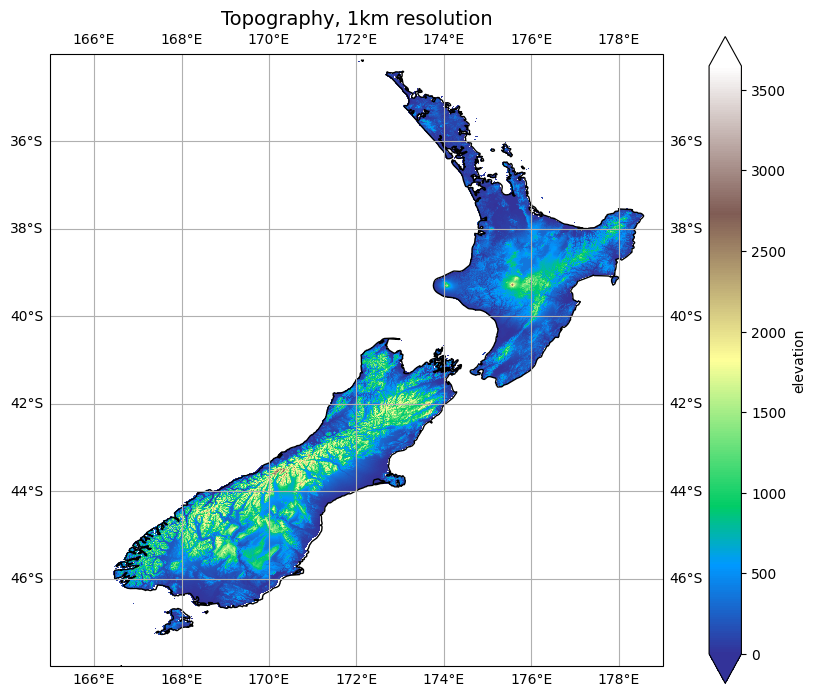

In [13]:
top_nzplot = PlotData()
# da.plot()  # ~2 min
top_nzplot.nz_map_with_coastlines()
top_da.plot(cbar_kwargs=cbar_kwargs, cmap="terrain", vmin=0)
plt.title("Topography, 1km resolution", fontsize=14)
# plt.savefig('./tmp/fig.png')
plt.show()

### Stations

In [14]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [15]:
var = "temperature"
process_stations = ProcessStations()
all_stations = process_stations.get_path_all_stations(var)

In [16]:
date = "2016-07-01"
df_date = None
for f in tqdm(all_stations):
    df_stations = process_stations.load_station_df(f, var, daily=True)
    try:
        station_at_date = df_stations[df_stations.index == date]
        if type(df_date) == pd.DataFrame:
            df_date = pd.concat([df_date, station_at_date])
        else:
            print("Creating df_date")
            df_date = station_at_date
    except:
        pass

  0%|          | 2/444 [00:00<00:48,  9.07it/s]

Creating df_date


  1%|          | 3/444 [00:00<00:56,  7.86it/s]

100%|██████████| 444/444 [00:42<00:00, 10.35it/s]


/home/emily/mambaforge/envs/deepsensor/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/home/emily/mambaforge/envs/deepsensor/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/home/emily/mambaforge/envs/deepsensor/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/home/emily/mambaforge/envs/deepsensor/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/home/emily/

<Figure size 1000x1000 with 0 Axes>

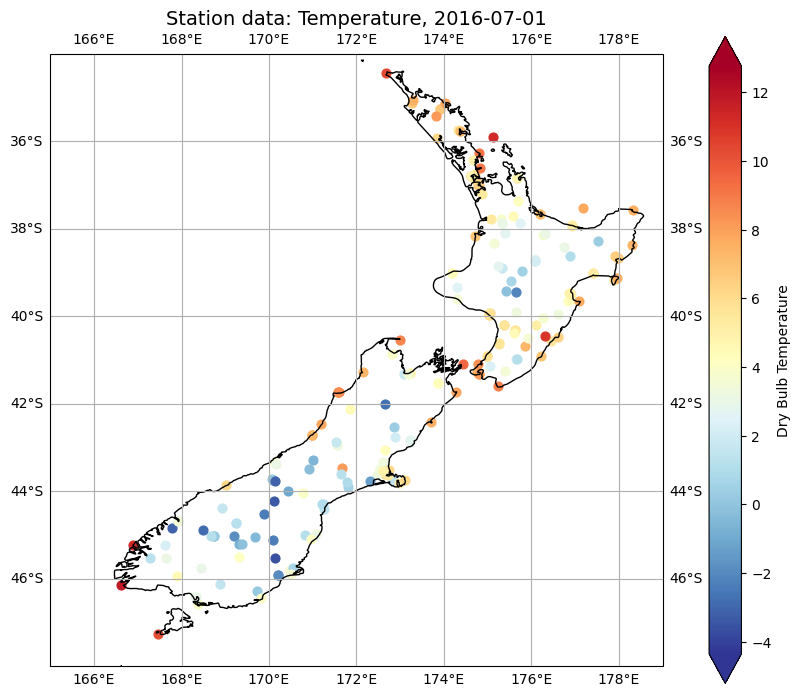

In [17]:
stations_date_plotnz = PlotData()
era5_fig = plt.figure(figsize=(10, 10))
stations_date_ax = stations_date_plotnz.nz_map_with_coastlines()
# vmin, vmax = df_date['dry_bulb'].min(), df_date['dry_bulb'].max()

norm = Normalize(vmin=min_value, vmax=max_value)
cmap = plt.get_cmap("RdYlBu_r")
sm = ScalarMappable(norm=norm, cmap=cmap)

for row in df_date.iterrows():
    lon = row[1]["longitude"]
    lat = row[1]["latitude"]
    color = sm.to_rgba(row[1]["dry_bulb"])

    stations_date_ax.scatter(
        lon,
        lat,
        color=color,
        marker="o",
        s=40,
        cmap=cmap,
        vmin=min_value,
        vmax=max_value,
    )

cbar = era5_fig.colorbar(sm, ax=stations_date_ax, **cbar_kwargs)
cbar.set_label("Dry Bulb Temperature")

plt.title(f"Station data: {var.capitalize()}, {date}", fontsize=14);

# # label_size = 14
# # plt.gca().tick_params(axis='x', labelsize=label_size)
# # plt.gca().tick_params(axis='y', labelsize=label_size)
# # plt.savefig('./tmp/fig.png')
# plt.show()

In [18]:
df

,start_year,end_year,duration_years,lon,lat,station_id
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/2473.nc,1978,1991,13,175.61100,-40.98000,2473
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/25162.nc,2003,2019,16,175.06906,-37.78832,25162
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/3910.nc,1980,2019,39,170.98428,-42.71228,3910
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/26170.nc,2006,2019,13,171.80500,-43.90500,26170
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/1192.nc,1990,1999,9,173.83500,-35.94400,1192
...,...,...,...,...,...,...
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/40983.nc,2015,2019,4,175.23805,-38.86145,40983
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/41163.nc,2012,2019,7,169.37549,-45.21452,41163
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/2136.nc,1979,2019,40,174.70700,-38.17100,2136
/mnt/datasets/NationalClimateDatabase/NetCDFFilesByVariableAndSite/Hourly/ScreenObs/3145.nc,1961,2012,51,174.98400,-40.90700,3145


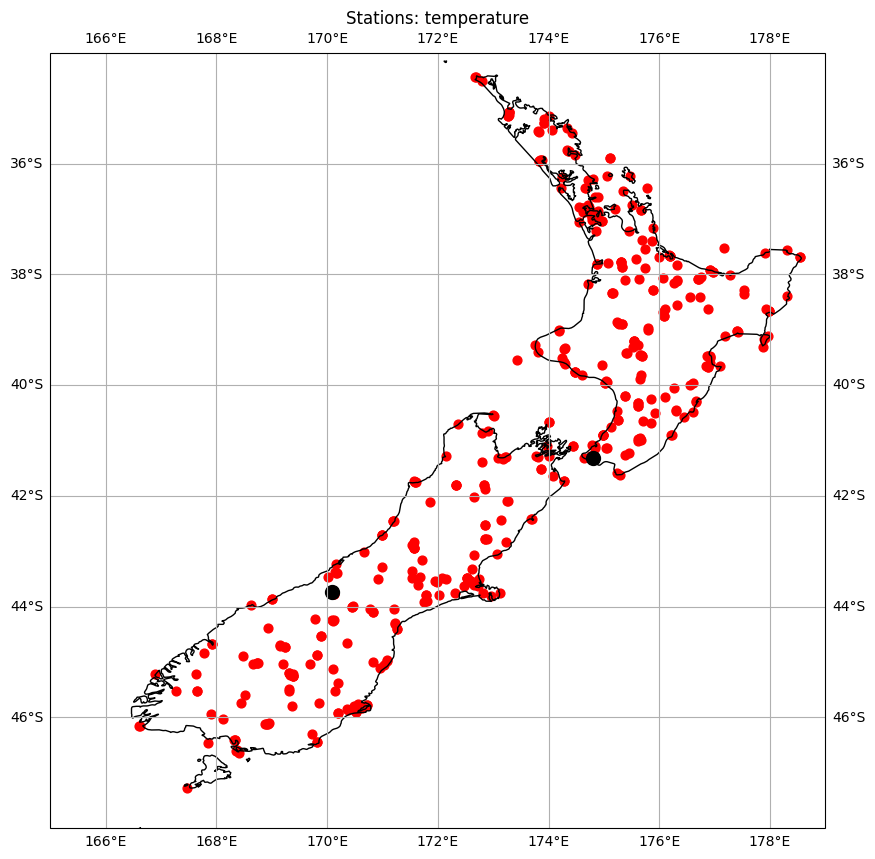

In [19]:
ax = process_stations.plot_stations_on_map(df)
parent_path = process_stations.get_parent_path("temperature")

from nzdownscale.dataprocess.config import STATION_LATLON

for station in ["WELLINGTON AERO", "MT COOK EWS"]:
    station_lat = STATION_LATLON[station]["latitude"]
    station_lon = STATION_LATLON[station]["longitude"]

    ax.scatter(station_lon, station_lat, color="black", s=100)


plt.title(f"Stations: {var}")
# plt.savefig('./tmp/fig.png')
plt.show()